# <span style="color:#6495ED">**Abnormal behavior in cellular networks predictor**</span>

Gil Jiménez Canellas, Machine Learning Seminar, ETSETB, UPC. 2024

> Competition Link: https://www.kaggle.com/competitions/abnomal-behavior-in-cellular-networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

### <span style="color:#6495ED">**1. Division between train and test data**</span>

First we are going to make the division between train and test data using `train_test_split`.

In [4]:
path = '/home/gil/Telecos/3B/APA/LAB/Competition/data/'
train = pd.read_csv(path + 'ML-MATT-CompetitionQT2021_train.csv', delimiter=';')
test = pd.read_csv(path + 'ML-MATT-CompetitionQT2021_test.xls', delimiter=';')

# from google.colab import drive
# drive.mount('/content/drive')
# file_path_train = '/content/drive/My Drive/APA/Competition/data/ML-MATT-CompetitionQT2021_train.csv'
# file_path_test = '/content/drive/My Drive/APA/Competition/data/ML-MATT-CompetitionQT2021_test.csv'
# train = pd.read_csv(file_path_train, delimiter=';')
# test = pd.read_csv(file_path_test, delimiter=';')

print("Number of rows:", train.shape[0])
print("Number of columns:", train.shape[1])

Number of rows: 36904
Number of columns: 14


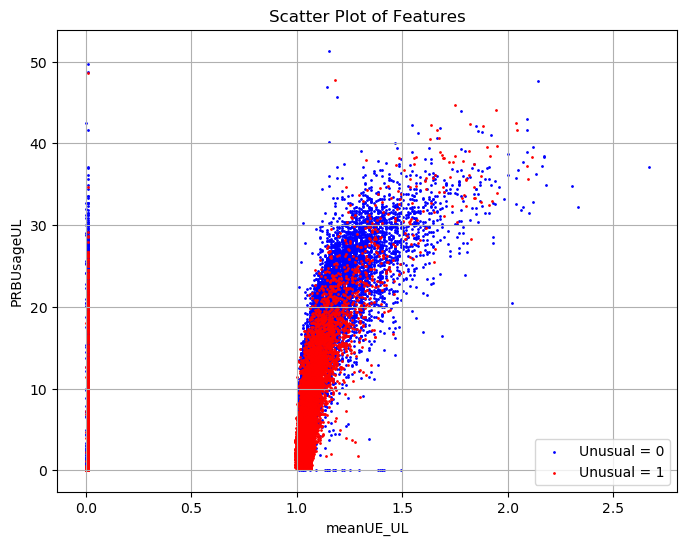

In [86]:
unusual_0 = train[train['Unusual'] == 0]
unusual_1 = train[train['Unusual'] == 1]

plt.figure(figsize=(8, 6))
plt.scatter(unusual_0['meanUE_UL'], unusual_0['PRBUsageUL'], color='blue', label='Unusual = 0', s=1)
plt.scatter(unusual_1['meanUE_UL'], unusual_1['PRBUsageUL'], color='red', label='Unusual = 1', s=1)
plt.xlabel('meanUE_UL')
plt.ylabel('PRBUsageUL')
plt.title('Scatter Plot of Features')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
train['Time'] = pd.to_datetime(train['Time'], format='%H:%M')
train['Time'] = (train['Time'].dt.hour * 60 + train['Time'].dt.minute) / 1440 * 360
train['Time1'] = np.sin(np.deg2rad(train['Time']))
train['Time2'] = np.cos(np.deg2rad(train['Time']))
train = train.drop(columns='Time')

print(train.head())

  CellName  PRBUsageUL  PRBUsageDL  meanThr_DL  meanThr_UL  maxThr_DL  \
0    3BLTE     12.3848      1.4019      0.3927      0.0438    16.6522   
1    1BLTE     22.0438      2.0016      0.5620      0.2697    10.3994   
2    9BLTE      0.5105      0.4258      0.0152      0.0106     0.2755   
3    4ALTE      1.9963      1.1513      0.9908      0.0245    64.7465   
4   10BLTE      0.3030      0.4040      0.0160      0.0130     0.3480   

   maxThr_UL  meanUE_DL  meanUE_UL  maxUE_DL  maxUE_UL  maxUE_UL+DL  Unusual  \
0     0.6806     1.1293     1.0491         5         3            8        1   
1     1.1771     1.4480     1.1630         6         5           11        1   
2     0.1685     1.0379     1.0535         1         2            3        1   
3     0.8747     1.0766     1.0526         3         2            5        1   
4     0.1680     1.0110     1.0110         2         1            3        0   

      Time1     Time2  
0  0.321439 -0.946930  
1  0.555570 -0.831470  
2  0.896

In [6]:
test['Time'] = pd.to_datetime(test['Time'], format='%H:%M')
test['Time'] = (test['Time'].dt.hour * 60 + test['Time'].dt.minute) / 1440 * 360
test['Time1'] = np.sin(np.deg2rad(test['Time']))
test['Time2'] = np.cos(np.deg2rad(test['Time']))
test = test.drop(columns='Time')

print(test.head())

  CellName  PRBUsageUL  PRBUsageDL  meanThr_DL  meanThr_UL  maxThr_DL  \
0    6ALTE      3.8177      1.5251      0.5829      0.0445    23.1688   
1    6ULTE      2.0210      3.3350      0.5690      0.0750    29.2650   
2    2ALTE      0.5050      0.4040      0.0140      0.0100     0.2270   
3    3CLTE      1.0110      0.5050      0.2380      0.0210    20.9620   
4    6CLTE      4.0269      0.5104      0.0807      0.0414     3.9317   

   maxThr_UL  meanUE_DL  meanUE_UL  maxUE_DL  maxUE_UL  maxUE_UL+DL     Time1  \
0     0.7669     1.0262     0.0100         3         3            6  0.707107   
1     1.0490     1.3140     0.0100         6         3            9 -0.793353   
2     0.0970     1.0110     0.0100         2         1            3  0.130526   
3     0.6090     1.0110     1.0110         2         1            3  0.980785   
4     1.7811     1.0575     0.0107         3         2            5 -0.831470   

      Time2  
0  0.707107  
1  0.608761  
2 -0.991445  
3 -0.195090  
4 -0

In [7]:
# Drop CellName and prepare Time
train = train.drop(columns=['CellName'])

# Drop CellName and prepare Time
test = test.drop(columns=['CellName'])

# # Remove all non-numeric characters
# test['maxThr_DL'] = test['maxThr_DL'].replace('[^\d]', '', regex=True)
# test['maxThr_DL'] = test['maxThr_DL'].str.replace(r'(\d+\.\d+)(.*)', r'\1', regex=True).astype(float)

print(train.head())
print(test.head())

   PRBUsageUL  PRBUsageDL  meanThr_DL  meanThr_UL  maxThr_DL  maxThr_UL  \
0     12.3848      1.4019      0.3927      0.0438    16.6522     0.6806   
1     22.0438      2.0016      0.5620      0.2697    10.3994     1.1771   
2      0.5105      0.4258      0.0152      0.0106     0.2755     0.1685   
3      1.9963      1.1513      0.9908      0.0245    64.7465     0.8747   
4      0.3030      0.4040      0.0160      0.0130     0.3480     0.1680   

   meanUE_DL  meanUE_UL  maxUE_DL  maxUE_UL  maxUE_UL+DL  Unusual     Time1  \
0     1.1293     1.0491         5         3            8        1  0.321439   
1     1.4480     1.1630         6         5           11        1  0.555570   
2     1.0379     1.0535         1         2            3        1  0.896873   
3     1.0766     1.0526         3         2            5        1  0.659346   
4     1.0110     1.0110         2         1            3        0  0.793353   

      Time2  
0 -0.946930  
1 -0.831470  
2 -0.442289  
3  0.751840  
4  0

In [9]:
# Separate majority and minority classes
normal = train[train['Unusual'] == 0]
abnormal = train[train['Unusual'] == 1]

# Undersample majority class to match the desired ratio
from sklearn.utils import resample
desired_normal_count = int(len(abnormal) / 0.5 * 0.5)  # Calculate the desired number of samples for the majority class
undersampled_normal = resample(normal, replace=False, n_samples=desired_normal_count, random_state=42)

# Combine minority class with undersampled majority class
train = pd.concat([undersampled_normal, abnormal])

# Shuffle the dataframe
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

print("Percentage of 1s in balanced data:", (train['Unusual'] == 1).mean() * 100)
print("Percentage of 0s in balanced data:", (train['Unusual'] == 0).mean() * 100)

X = train.drop('Unusual', axis=1)
y = train['Unusual']

print(X.head())
print(y.head())
print(test.head())

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Percentage of 1s in balanced data: 50.0
Percentage of 0s in balanced data: 50.0
   PRBUsageUL  PRBUsageDL  meanThr_DL  meanThr_UL  maxThr_DL  maxThr_UL  \
0     20.3531      6.2096      1.0809      0.9075    20.5033     1.7199   
1      1.0110      0.5050      0.3180      0.0350     8.4680     0.5380   
2      6.8391      1.0124      0.2372      0.0293     7.9899     0.6414   
3      1.0065      2.1870      0.1972      0.0266    11.8405     0.4458   
4      0.1030      0.3975      0.0330      0.0120     0.1442     0.0359   

   meanUE_DL  meanUE_UL  maxUE_DL  maxUE_UL  maxUE_UL+DL     Time1     Time2  
0     1.3668     1.2330         6         4           10 -0.555570  0.831470  
1     1.0210     1.0110         2         2            4  0.980785 -0.195090  
2     1.1624     1.1281         5         4            9  0.321439 -0.946930  
3     1.1357     0.0100         4         4            8 -0.997859 -0.065403  
4     1.0337     0.0101         2         1            3  0.382683  0.9238

In [19]:
selected_features = ['meanUE_UL', 'PRBUsageUL', 'PRBUsageDL']

X_train = X_train[selected_features]
X_test = X_test[selected_features]
test = test[selected_features]

Here I tryied KMeans.

In [25]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit KMeans on the training data
kmeans.fit(X_train)

# Predict clusters for training and testing data
y_pred = kmeans.predict(X_test)

y_test.to_numpy()

# You can use the clusters as pseudo-labels
# For example, you can calculate accuracy_score using these pseudo-labels
train_accuracy = accuracy_score(y_pred, y_test.to_numpy())

print("Training accuracy:", train_accuracy)

/home/gil/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Training accuracy: 0.5276595744680851


Here I normalized tha data just to try if improves. I didn't use it in the final submission.

In [6]:
normalized_data = (X_test['meanUE_UL'] - X_test['meanUE_UL'].min(axis=0)) / (X_test['meanUE_UL'].max(axis=0) - X_test['meanUE_UL'].min(axis=0))
X_test['meanUE_UL'] = normalized_data

normalized_data = (X_test['PRBUsageUL'] - X_test['PRBUsageUL'].min(axis=0)) / (X_test['PRBUsageUL'].max(axis=0) - X_test['PRBUsageUL'].min(axis=0))
X_test['PRBUsageUL'] = normalized_data

normalized_data = (X_test['PRBUsageDL'] - X_test['PRBUsageDL'].min(axis=0)) / (X_test['PRBUsageDL'].max(axis=0) - X_test['PRBUsageDL'].min(axis=0))
X_test['PRBUsageDL'] = normalized_data


normalized_data = (test['meanUE_UL'] - test['meanUE_UL'].min(axis=0)) / (test['meanUE_UL'].max(axis=0) - test['meanUE_UL'].min(axis=0))
test['meanUE_UL'] = normalized_data

normalized_data = (test['PRBUsageUL'] - test['PRBUsageUL'].min(axis=0)) / (test['PRBUsageUL'].max(axis=0) - test['PRBUsageUL'].min(axis=0))
test['PRBUsageUL'] = normalized_data

normalized_data = (test['PRBUsageDL'] - test['PRBUsageDL'].min(axis=0)) / (test['PRBUsageDL'].max(axis=0) - test['PRBUsageDL'].min(axis=0))
test['PRBUsageDL'] = normalized_data


normalized_data = (X_train['meanUE_UL'] - X_train['meanUE_UL'].min(axis=0)) / (X_train['meanUE_UL'].max(axis=0) - X_train['meanUE_UL'].min(axis=0))
X_train['meanUE_UL'] = normalized_data

normalized_data = (X_train['PRBUsageUL'] - X_train['PRBUsageUL'].min(axis=0)) / (X_train['PRBUsageUL'].max(axis=0) - X_train['PRBUsageUL'].min(axis=0))
X_train['PRBUsageUL'] = normalized_data

normalized_data = (X_train['PRBUsageDL'] - X_train['PRBUsageDL'].min(axis=0)) / (X_train['PRBUsageDL'].max(axis=0) - X_train['PRBUsageDL'].min(axis=0))
X_train['PRBUsageDL'] = normalized_data

print(X_train.head())
print(X_test.head())
print(test.head())


       meanUE_UL  PRBUsageUL  PRBUsageDL
3484    0.441731    0.159754    0.011962
12622   0.453685    0.179376    0.029368
8058    0.478149    0.216292    0.021834
16162   0.004542    0.002141    0.010847
13789   0.004327    0.019501    0.024982
       meanUE_UL  PRBUsageUL  PRBUsageDL
18022   0.483245    0.152443    0.010466
1288    0.505396    0.022063    0.016039
10373   0.004733    0.012189    0.043625
16231   0.004828    0.000000    0.007331
10594   0.004733    0.040650    0.045370
   meanUE_UL  PRBUsageUL  PRBUsageDL
0   0.000451    0.082308    0.052373
1   0.000451    0.004357    0.011453
2   0.000451    0.001089    0.001387
3   0.045639    0.002180    0.001734
4   0.000483    0.086819    0.001753


More tries, mlpclassifier.

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# Define the number of folds
num_folds = 5

# Initialize a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store scores
train_scores = []
test_scores = []

# Define MLPClassifier parameters
mlp_params = {
    'hidden_layer_sizes': (50,),  # Example hidden layer configuration, adjust as needed
    'activation': 'relu',           # Activation function for hidden layers
    'solver': 'adam',               # Optimization algorithm
    'alpha': 0.0001,                # L2 regularization term
    'batch_size': 'auto',
    'learning_rate': 'constant',
    'learning_rate_init': 0.001,
    'max_iter': 200,                # Maximum number of iterations
    'random_state': 42
}

# Iterate over each fold
for train_index, test_index in kf.split(X):
    # Split the data into train and test sets for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train MLPClassifier model
    mlp = MLPClassifier(**mlp_params)
    mlp.fit(X_train_fold, y_train_fold)
    
    # Predict on the training data for this fold
    y_train_pred = mlp.predict(X_train_fold)
    # Calculate the training accuracy for this fold
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    train_scores.append(train_accuracy)
    
    # Predict on the test data for this fold
    y_test_pred = mlp.predict(X_test_fold)
    # Calculate the test accuracy for this fold
    test_accuracy = accuracy_score(y_test_fold, y_test_pred)
    test_scores.append(test_accuracy)

# Calculate the average scores across all folds
avg_train_score = np.mean(train_scores)
avg_test_score = np.mean(test_scores)

print("Average training accuracy across all folds:", avg_train_score)
print("Average testing accuracy across all folds:", avg_test_score)


Average training accuracy across all folds: 0.5952691556832844
Average testing accuracy across all folds: 0.5949623350293087


XGBoost.

In [12]:
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store F1 scores
train_f1_scores = []
test_f1_scores = []

# Initialize XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,  # Learning rate
    'max_depth': 6,  # Maximum depth of a tree
    'min_child_weight': 1,  # Minimum sum of instance weight needed in a child
    'subsample': 0.8,  # Subsample ratio of the training instance
    'colsample_bytree': 0.8,  # Subsample ratio of columns when constructing each tree
    'alpha': 0.1,  # L1 regularization term on weights
    'lambda': 0.1,  # L2 regularization term on weights
    'random_state': 42,
    'verbosity': 0  # Set to 0 for no output during training
}

# Initialize KFold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Iterate over each fold
for train_index, test_index in kf.split(X):
    # Split the data into train and test sets for this fold
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train XGBoost model
    model = xgb.XGBClassifier(**xgb_params)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the training data for this fold
    y_train_pred = model.predict(X_train_fold)
    # Calculate the F1 score for this fold on training data
    train_f1 = f1_score(y_train_fold, y_train_pred)
    train_f1_scores.append(train_f1)
    
    # Predict on the test data for this fold
    y_test_pred = model.predict(X_test_fold)
    # Calculate the F1 score for this fold on test data
    test_f1 = f1_score(y_test_fold, y_test_pred)
    test_f1_scores.append(test_f1)

# Calculate the average F1 scores across all folds
avg_train_f1_score = np.mean(train_f1_scores)
avg_test_f1_score = np.mean(test_f1_scores)

print("Average training F1 score across all folds:", avg_train_f1_score)
print("Average testing F1 score across all folds:", avg_test_f1_score)

Average training F1 score across all folds: 0.9371104416812598
Average testing F1 score across all folds: 0.9157863518416575


SVC

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# Define the portion of the dataset to use
sample_size = 0.1 

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-sample_size, random_state=42)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store F1 scores
train_f1_scores = []
test_f1_scores = []

# Initialize SVC with linear kernel
svc_model = SVC(kernel='linear', random_state=42)

# Initialize KFold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Iterate over each fold
for train_index, test_index in kf.split(X_train):
    # Split the data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train SVC model
    svc_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the training data for this fold
    y_train_pred = svc_model.predict(X_train_fold)
    # Calculate the F1 score for this fold on training data
    train_f1 = f1_score(y_train_fold, y_train_pred)
    train_f1_scores.append(train_f1)
    
    # Predict on the validation data for this fold
    y_val_pred = svc_model.predict(X_val_fold)
    # Calculate the F1 score for this fold on validation data
    val_f1 = f1_score(y_val_fold, y_val_pred)
    test_f1_scores.append(val_f1)

# Calculate the average F1 scores across all folds
avg_train_f1_score = np.mean(train_f1_scores)
avg_test_f1_score = np.mean(test_f1_scores)

print("Average training F1 score across all folds:", avg_train_f1_score)
print("Average testing F1 score across all folds:", avg_test_f1_score)


Average training F1 score across all folds: 0.6426023197843518
Average testing F1 score across all folds: 0.6374345909508449


XGBoost with gridsearch

In [13]:
import xgboost as xgb

# Initialize and train XGBoost model on the entire training dataset
model = xgb.XGBClassifier(**xgb_params)
model.fit(X, y)

# Make predictions on the test data
test_predictions = model.predict(test)

In [6]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(verbosity=0, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X, y)

# Print the best parameters found
print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; tot

In [14]:
import xgboost as xgb

# Initialize and train XGBoost model on the entire training dataset
# model = grid_search

# # Make predictions on the test data
# test_predictions = model.predict(test)

# Assuming you want to save the predictions to a CSV file
# Create a DataFrame with the predicted values and the corresponding IDs
predictions_df = pd.DataFrame({'ID': range(1, len(test_predictions)+1), 'Unusual': test_predictions})

# Save the predictions to a CSV file
predictions_df.to_csv('prediction19.csv', index=False)

### <span style="color:#6495ED">**2. Evaluation of several supervised learning models**</span>

In this second bloc, we are going to evaluate several supervised learning models, to find which models have the best `F1-score`. The models that we are going to try are the following ones:

* RandomForestClassifier
* DecisionTreeClassifier
* GaussianNB
* KNeighborsClassifier
* AdaBoostClassifier


  
---
---

Each estimator is associated with a tuple consisting of the classification model and a dictionary of hyperparameters with their possible values. This will allow exploring different combinations of estimators and hyperparameters to find the best configuration for our specific classification problem.

In [69]:
estimators = [
    (RandomForestClassifier(), {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}),
    (DecisionTreeClassifier(), {'max_depth': [None, 5, 10]}),
    (AdaBoostClassifier(), {'n_estimators': [50, 100, 200]}),
    (KMeans(), {'n_clusters': [2, 3, 4]}),
]

In [70]:
estimator_names = []
accuracy_scores = []
recall_scores = []
f1_scores = []

for estimator, param_grid in estimators:
    grid_search = GridSearchCV(estimator, param_grid)
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_

    best_estimator.fit(X_train, y_train)
    y_pred = best_estimator.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    estimator_names.append(best_estimator.__class__.__name__)
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)
    f1_scores.append(f1)
    print(grid_search.best_params_ )

{'max_depth': None, 'n_estimators': 100}
{'max_depth': None}
{'n_estimators': 200}


/home/gil/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gil/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gil/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gil/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

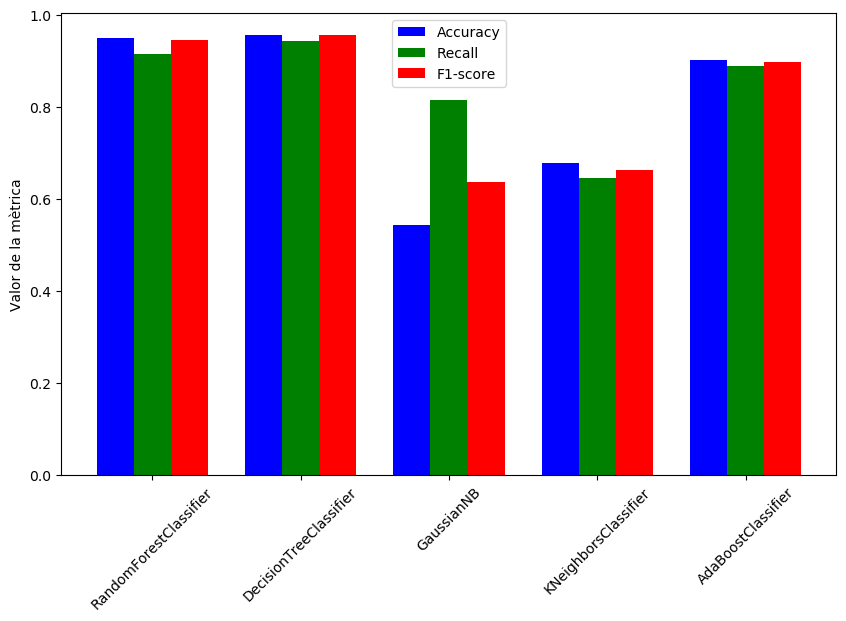

In [58]:
plt.figure(figsize=(10, 6))
x = range(len(estimator_names))
bar_width = 0.25

plt.bar(x, accuracy_scores, width=bar_width, label='Accuracy', color='b')
plt.bar([i + bar_width for i in x], recall_scores, width=bar_width, label='Recall', color='g')
plt.bar([i + 2 * bar_width for i in x], f1_scores, width=bar_width, label='F1-score', color='r')

plt.ylabel('Valor de la mètrica')
plt.xticks([i + bar_width for i in x], estimator_names, rotation=45)
plt.legend()

plt.show()

We are going to choose the three best models, based on the performance.

In [ ]:
f1 = np.array(f1_scores)
estimator_name = np.array(estimator_names)
indices_top3 = np.argsort(f1)[-3:]

for indice in indices_top3:
    print("Estimador:", estimator_name[indice])
    print("F1-score:", f1[indice])
    print("-----------------------")

Estimador: AdaBoostClassifier
F1-score: 0.8991105463786531
-----------------------
Estimador: RandomForestClassifier
F1-score: 0.9135865409125669
-----------------------
Estimador: DecisionTreeClassifier
F1-score: 0.9210261569416499
-----------------------


# 3. Decision Tree

In [10]:
param_grid = {
    'max_depth': [50, 60, 70],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
decision_tree = DecisionTreeClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(decision_tree, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_decision_tree = grid_search.best_estimator_

print(best_decision_tree)

DecisionTreeClassifier(max_depth=70, min_samples_leaf=4, min_samples_split=10)


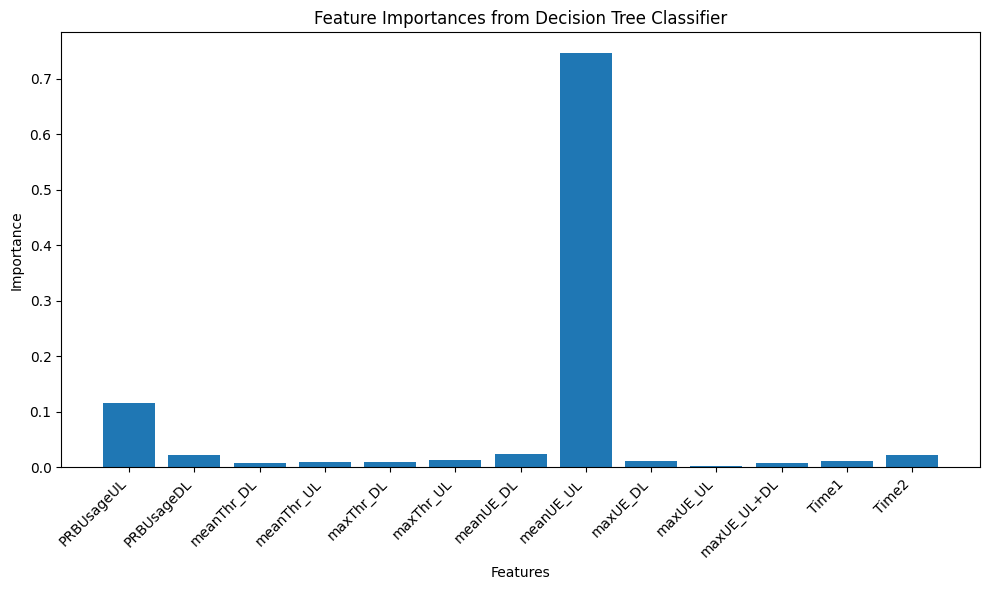

In [12]:
importances = best_decision_tree.feature_importances_

feature_names = list(X_train.columns)

# sorted_indices = importances.argsort()[::-1]
# sorted_features = [feature_names[i] for i in sorted_indices]
# sorted_importances = importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances, align='center')
plt.xticks(range(len(importances)), feature_names, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Decision Tree Classifier')
plt.tight_layout()
plt.show()

In [56]:
print("Feature Importances:")
for i, importance in enumerate(best_decision_tree.feature_importances_):
    print(f"Feature {i}: {importance}")

Feature Importances:
Feature 0: 0.8239738112319738
Feature 1: 0.13473424717136948
Feature 2: 0.04129194159665691


In [15]:
selected_features = ['meanUE_UL', 'PRBUsageUL', 'Time', 'PRBUsageDL', 'meanUE_DL']

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [90]:
param_grid = {
    'max_depth': [4, 2],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Decision Tree Classifier
decision_tree = DecisionTreeClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(decision_tree, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_selected, y_train)

# Get the best estimator from the grid search
best_decision_tree = grid_search.best_estimator_

print(best_decision_tree)

NameError: name 'X_train_selected' is not defined

In [13]:
print("Feature Importances:")
for i, importance in enumerate(best_decision_tree.feature_importances_):
    print(f"Feature {i}: {importance}")

Feature Importances:
Feature 0: 0.11617839962108124
Feature 1: 0.02124626168671224
Feature 2: 0.007336228210330312
Feature 3: 0.00969598956461409
Feature 4: 0.0095711596328159
Feature 5: 0.012404480610440563
Feature 6: 0.022823440108572516
Feature 7: 0.7467582133497235
Feature 8: 0.010700914701292702
Feature 9: 0.002791845322941453
Feature 10: 0.007878260996041863
Feature 11: 0.011646349766013963
Feature 12: 0.020968456429419635


In [57]:
dt = best_decision_tree

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.958368165858552


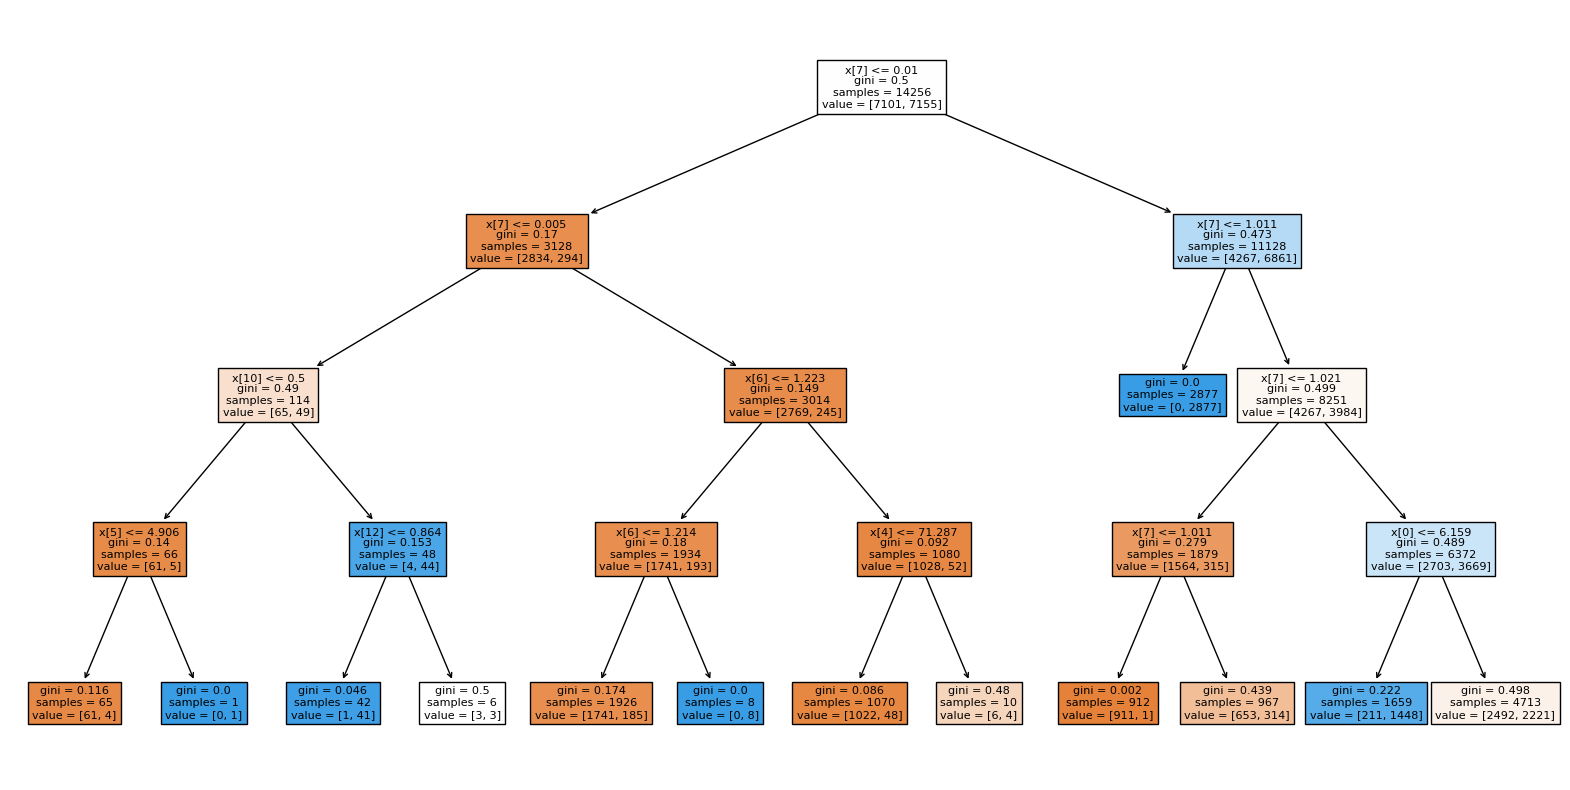

In [100]:
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plot_tree(dt, filled=True) #, feature_names=X.feature_names, class_names=iris.target_names)
plt.show()

# 4.Random Forest

In [16]:
# Define parameter grid for Random Forest
param_grid = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}

# Initialize Random Forest Classifier
random_forest = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(random_forest, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# Get the best estimator from the grid search
best_random_forest = grid_search.best_estimator_

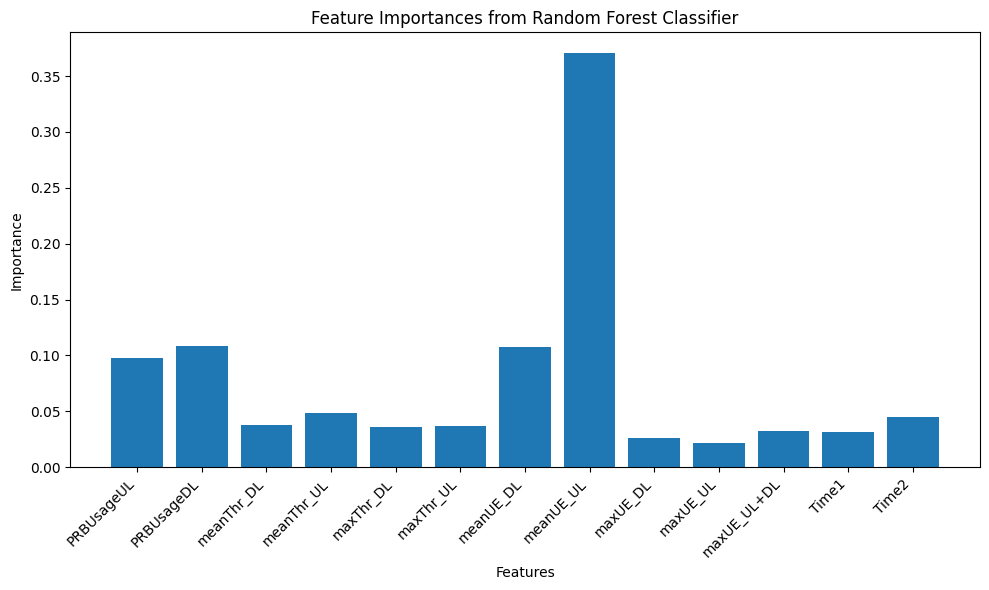

In [19]:
importances = best_random_forest.feature_importances_

feature_names = list(X_train.columns)

# sorted_indices = importances.argsort()[::-1]
# sorted_features = [feature_names[i] for i in sorted_indices]
# sorted_importances = importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances, align='center')
plt.xticks(range(len(importances)), feature_names, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest Classifier')
plt.tight_layout()
plt.show()

In [59]:
rf = best_random_forest

rf.fit(X_train, y_train.values.ravel())

y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.9373390557939915


# 5.Ada Boost

In [14]:
# Define parameter grid for AdaBoost
param_grid = {
    'n_estimators': [50, 75, 100],  # Number of weak learners
    'learning_rate': [0.01, 0.1, 1.0],  # Weight of each weak learner
}

# Initialize AdaBoost Classifier
adaboost = AdaBoostClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(adaboost, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train.values.ravel())  # ravel() to convert y_train to 1D array

# Get the best estimator from the grid search
best_adaboost = grid_search.best_estimator_

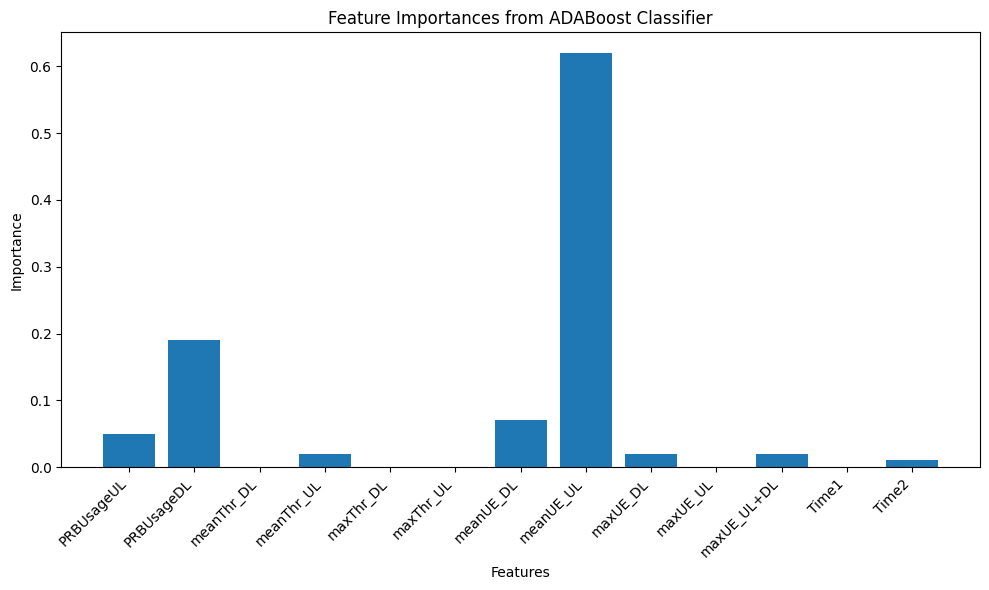

In [18]:
importances = best_adaboost.feature_importances_

feature_names = list(X_train.columns)

# sorted_indices = importances.argsort()[::-1]
# sorted_features = [feature_names[i] for i in sorted_indices]
# sorted_importances = importances[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances, align='center')
plt.xticks(range(len(importances)), feature_names, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from ADABoost Classifier')
plt.tight_layout()
plt.show()

In [63]:
ab = best_adaboost

# Train the best estimator on the entire training data
ab.fit(X_train, y_train.values.ravel())

y_pred = ab.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.7975530491301854


In [67]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=1,
              scale_pos_weight=7,
              colsample_bytree= 0.13137077780333722,
              eta= 0.44303994079253584,
              gamma= 0.44387153143053776,
              learning_rate= 0.36592512350123696,
              max_depth= 16,
              min_child_weight= 1,
              n_estimators= 743,
              subsample= 0.9954777036558068)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)

0.8915327564894932


# 6. Voting

In [69]:
from sklearn.ensemble import VotingClassifier
voting_hard = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('ab', ab)],
    voting='hard'
)
voting_hard.fit(X_train, y_train)

voting_soft2 = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('xgb', xgb)],
    voting='soft'
)
voting_soft2.fit(X_train, y_train)

voting_soft = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('ab', ab)],
    voting='soft'
)
voting_soft.fit(X_train, y_train)

models = [('dt', dt), ('rf', rf), ('ab', ab), ('hard voting', voting_hard), ('s2', voting_soft2), ('soft voting', voting_soft)]

for name, model in models:
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print(f'Model: {name}')
    print(f'Accuracy: {accuracy}')
    print(f'F1-score: {f1}')
    print(f'Recall: {recall}')
    print('Confusion Matrix:')
    print(confusion_mat)
    print('------------------------')

Model: dt
Accuracy: 0.977510838150289
F1-score: 0.958368165858552
Recall: 0.9369074861065708
Confusion Matrix:
[[7957   56]
 [ 193 2866]]
------------------------
Model: rf
Accuracy: 0.9670339595375722
F1-score: 0.9373390557939915
Recall: 0.8924485125858124
Confusion Matrix:
[[7977   36]
 [ 329 2730]]
------------------------
Model: ab
Accuracy: 0.904353323699422
F1-score: 0.7975530491301854
Recall: 0.6819221967963387
Confusion Matrix:
[[7927   86]
 [ 973 2086]]
------------------------
Model: hard voting
Accuracy: 0.9695628612716763
F1-score: 0.9419265896949853
Recall: 0.8934292252370055
Confusion Matrix:
[[8002   11]
 [ 326 2733]]
------------------------
Model: s2
Accuracy: 0.9804010115606936
F1-score: 0.9637305699481864
Recall: 0.9424648577966656
Confusion Matrix:
[[7972   41]
 [ 176 2883]]
------------------------
Model: soft voting
Accuracy: 0.979317196531792
F1-score: 0.961596511822908
Recall: 0.9372343903236352
Confusion Matrix:
[[7976   37]
 [ 192 2867]]
----------------------

# 7. Submission

In [65]:
model = voting_soft
predictions = model.predict(test)

In [66]:
submission_df = pd.DataFrame({'ID': range(1, len(predictions)+1), 'Label': predictions})
submission_df.to_csv('prediction30.csv', index=False)